# Life Expectancy Data Science Project

---------------------------------------------

### Introduction
This analysis explores a life expectancy dataset, aiming to uncover factors affecting life expectancy across countries over time. We'll handle missing values, engineer features, perform exploratory analysis, visualize patterns, and build a regression model to predict life expectancy.

### Objectives
- Understand the structure and quality of the dataset
- Identify key features affecting life expectancy
- Handle missing data appropriately
- Engineer new features to improve prediction
- Visualize relationships and trends
- Build a regression model to predict life expectancy
- Evaluate model performance using cross-validation
- Derive actionable insights

### Task 1: Explore Dataset and Missing Values

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
df = pd.read_csv('Life_Expectancy_Data.csv')
df.shape 

(1649, 22)

In [6]:
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                      int64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                          int64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                                int64
Total expenditure                  float64
Diphtheria                           int64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [7]:
df.dtypes.value_counts()

float64    12
int64       8
object      2
Name: count, dtype: int64

In [8]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [9]:
for column in df.columns:
    df.rename(columns={column: column.strip()}, inplace=True)

df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [10]:
df.head(20)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,...,6,8.16,65,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,...,58,8.18,62,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,...,62,8.13,64,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,...,67,8.52,67,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,...,68,7.87,68,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,...,66,9.20,66,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281,77,0.01,56.762217,63,2861,...,63,9.42,63,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287,80,0.03,25.873925,64,1599,...,64,8.33,64,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295,82,0.02,10.910156,63,1141,...,63,6.73,63,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295,84,0.03,17.171518,64,1990,...,58,7.43,58,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [11]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool


In [12]:
#Find total of duplicated values
print(df.duplicated().sum())

0


### Task 2: Handle Missing Data and Justify Method

In [13]:
null_values = df.isnull().sum()

In [14]:
#Checks if any column has NaN
df.isnull().any()

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
BMI                                False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness  1-19 years               False
thinness 5-9 years                 False
Income composition of resources    False
Schooling                          False
dtype: bool

In [15]:
#Checks if any row has NaN
df.isnull().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool

In [16]:
#Checks if all values in a column are NaN
df.isnull().all()

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
BMI                                False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
HIV/AIDS                           False
GDP                                False
Population                         False
thinness  1-19 years               False
thinness 5-9 years                 False
Income composition of resources    False
Schooling                          False
dtype: bool

In [17]:
#Checks if all values in a row are NaN
df.isnull().all(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1644    False
1645    False
1646    False
1647    False
1648    False
Length: 1649, dtype: bool

In [18]:
null_percentage = (df.isnull().sum() / len(df))*100
print(null_percentage)

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64


In [19]:
missing_df = pd.DataFrame({'Missing Values': null_values, 'Percent Missing': null_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percent Missing


### Task 3: Apply Chosen Method and Evaluate

In [20]:
numeric_columns = df.select_dtypes(include = 'number')
df.fillna(df.mean(numeric_only=True), inplace=True)
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

In [21]:
nonNumericColumns = df.select_dtypes(include = 'object')
for column in nonNumericColumns.columns:
    df[column].fillna(df[column].mode()[0])
    
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

### Task 4: Identify Potential Features

In [22]:
#Description of the dataset transposed
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1649.0,2.007841e+03,4.087711e+00,2000.00000,2005.000000,2.008000e+03,2.011000e+03,2.015000e+03
Life expectancy,1649.0,6.930230e+01,8.796834e+00,44.00000,64.400000,7.170000e+01,7.500000e+01,8.900000e+01
Adult Mortality,1649.0,1.682153e+02,1.253104e+02,1.00000,77.000000,1.480000e+02,2.270000e+02,7.230000e+02
infant deaths,1649.0,3.255306e+01,1.208472e+02,0.00000,1.000000,3.000000e+00,2.200000e+01,1.600000e+03
Alcohol,1649.0,4.533196e+00,4.029189e+00,0.01000,0.810000,3.790000e+00,7.340000e+00,1.787000e+01
percentage expenditure,1649.0,6.989736e+02,1.759229e+03,0.00000,37.438577,1.451023e+02,5.093900e+02,1.896135e+04
Hepatitis B,1649.0,7.921771e+01,2.560466e+01,2.00000,74.000000,8.900000e+01,9.600000e+01,9.900000e+01
Measles,1649.0,2.224494e+03,1.008580e+04,0.00000,0.000000,1.500000e+01,3.730000e+02,1.314410e+05
BMI,1649.0,3.812862e+01,1.975425e+01,2.00000,19.500000,4.370000e+01,5.580000e+01,7.710000e+01
under-five deaths,1649.0,4.422013e+01,1.628980e+02,0.00000,1.000000,4.000000e+00,2.900000e+01,2.100000e+03


###  Task 5: Feature Engineering

In [23]:
df['Health Spending Ratio'] = df['Total expenditure'] / df['GDP']
df['Deaths per Infant'] = df['infant deaths'] / df['Population']

### Task 6: Impact of New Features

In [24]:
df[['Health Spending Ratio', 'Deaths per Infant']].describe()

,Health Spending Ratio,Deaths per Infant
count,1649.000000,1.649000e+03
mean,0.019220,3.643007e-04
std,0.073488,8.237884e-03
min,0.000028,0.000000e+00
25%,0.001131,4.399810e-08
50%,0.003121,1.343009e-06
75%,0.011613,1.178474e-05
max,1.659381,3.286604e-01


### Task 7: Select Key Variables for Visualization

In [25]:
df[['Life expectancy', 'GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']].corr()

,Life expectancy,GDP,Schooling,Alcohol,BMI,HIV/AIDS
Life expectancy,1.000000,0.441322,0.727630,0.402718,0.542042,-0.592236
GDP,0.441322,1.000000,0.467947,0.443433,0.266114,-0.108081
Schooling,0.727630,0.467947,1.000000,0.616975,0.554844,-0.211840
Alcohol,0.402718,0.443433,0.616975,1.000000,0.353396,-0.027113
BMI,0.542042,0.266114,0.554844,0.353396,1.000000,-0.210897
HIV/AIDS,-0.592236,-0.108081,-0.211840,-0.027113,-0.210897,1.000000


### Task 8: Visualizations

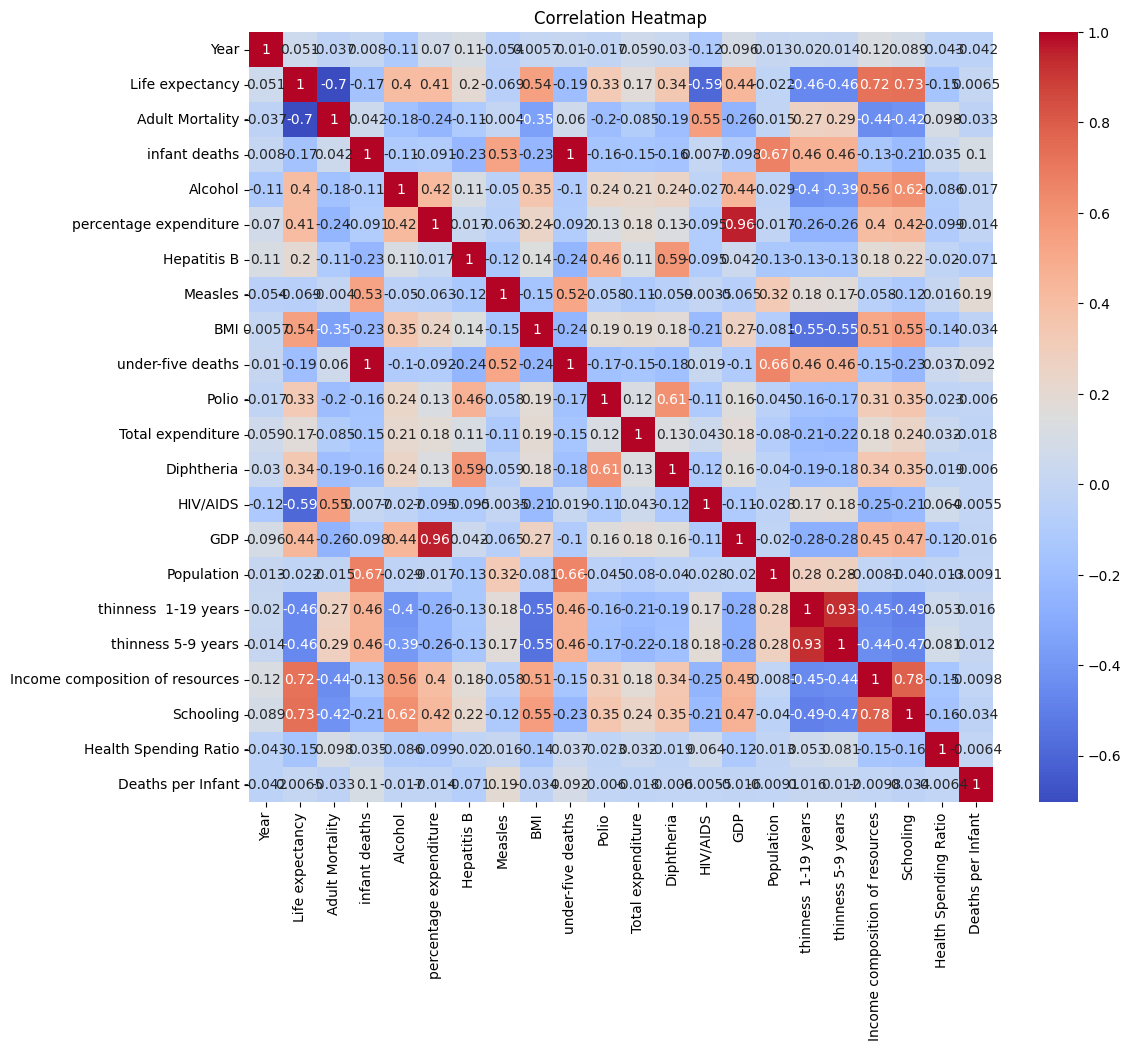

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

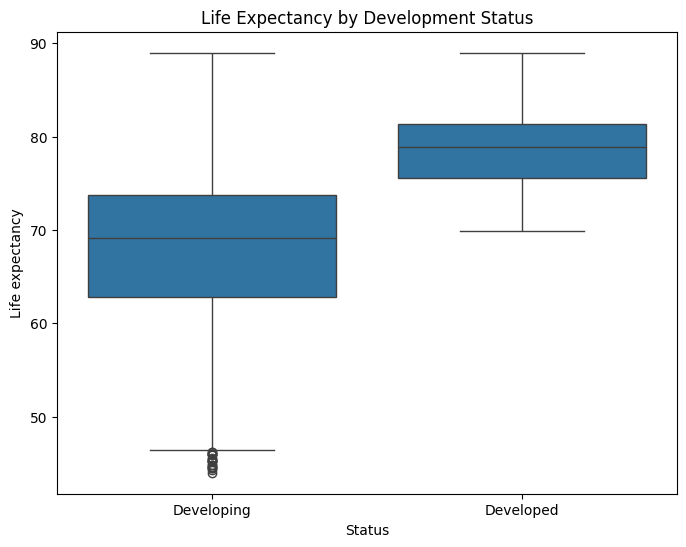

In [27]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Status', y='Life expectancy', data=df)
plt.title('Life Expectancy by Development Status')
plt.show()

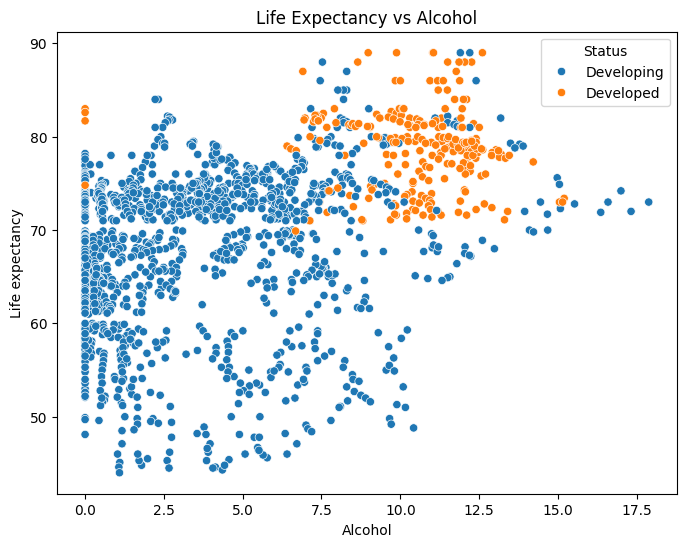

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Alcohol', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Alcohol')
plt.show()

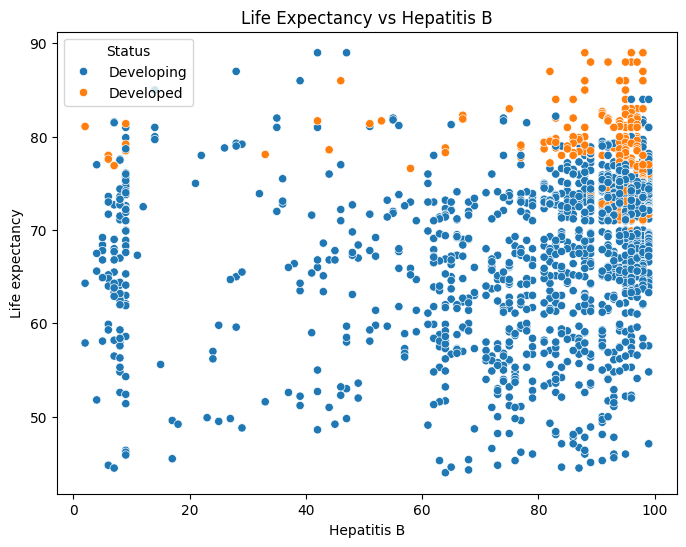

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Hepatitis B', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Hepatitis B')
plt.show()

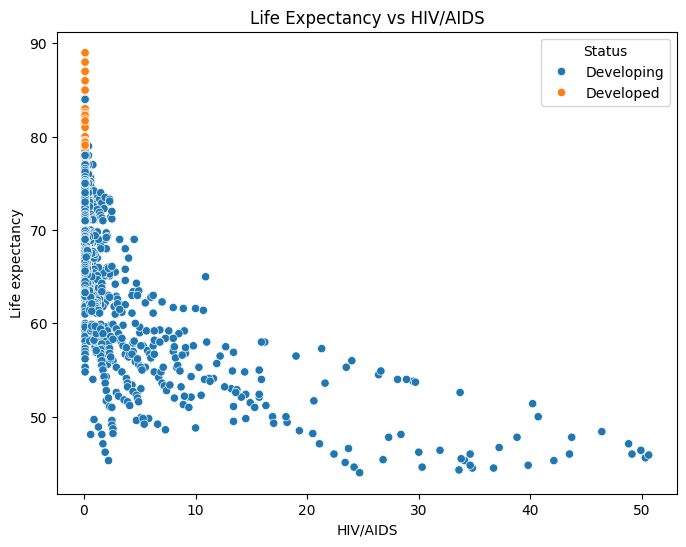

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x=' HIV/AIDS', y='Life expectancy ', hue='Status')
plt.title('Life Expectancy vs HIV/AIDS')
plt.show()

In [ ]:
# 3D Plot
fig = px.scatter_3d(df, x='GDP', y='Schooling', z='Life expectancy',
                     color='Status', size='Population')
plt.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Task 9: Interpretation
- Higher GDP and schooling are associated with higher life expectancy.
- Developing countries tend to have more outliers and lower average life expectancy.
- HIV/AIDS has a strong negative correlation with life expectancy.

### Task 10: Data Splitting and Model Training

In [ ]:
features = ['GDP', 'Schooling', 'Alcohol', 'BMI', 'HIV/AIDS']
X = df[features]
y = df['Life expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Task 11: Cross Validation and Model Evaluation

In [ ]:
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
cross_val = cross_val_score(model, X, y, cv=5).mean()
mae, r2, cross_val

(3.5007065323657645, 0.724406983884609, np.float64(0.7083935771445216))

### Task 12: Conclusion and Recommendations
- **Key Findings**: Life expectancy is positively influenced by GDP, schooling, and healthcare access. HIV/AIDS is a major negative predictor.
- **Model Performance**: The linear model gives reasonable accuracy with cross-validation.
- **Recommendation**: Focus on improving education, economic stability, and healthcare to raise life expectancy.